In [1]:
import os
import json
import wandb
import torch
import numpy as np


from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torchvision import models
from torchvision import transforms

from matplotlib import pyplot as plt
from tqdm.notebook import trange


from dataset import LabeledDataset, UnlabeledDataset

device = 'cuda' if torch.cuda.is_available else 'cpu'

In [2]:
normalization = transforms.Normalize([132., 126.4, 105.3], [67.8, 66.4, 70.5])

In [3]:
unldat = UnlabeledDataset('./data/', transform=normalization)
pretrain_loader = DataLoader(unldat, batch_size=50, shuffle=True, drop_last=True)

labdat = LabeledDataset('./data/train/labeled/', transform=normalization)
train_loader = DataLoader(labdat, batch_size=50, shuffle=True, drop_last=True)

In [16]:
stds = 1/torch.tensor([67.8, 66.4, 70.5])
means = -torch.tensor([132., 126.4, 105.3])*stds
denorm = transforms.Normalize(means, stds)
def to_img(X):
    with torch.no_grad():
        img = denorm(X)
    return img.transpose_(0,2).cpu()/255

In [4]:
model = models.resnet18(num_classes=10)

In [5]:
def forward_cut(X, model, level=-2):
    chs = list(model.children())[:level]
    res = X
    for ch in chs:
        X = res
        res = ch(X)
    return res

In [9]:
with open('versions.json', 'r') as f:
    versions = json.load(f)
versions['inpaint-pretrain'] += 1
cur_ver = versions['inpaint-pretrain']
with open('versions.json', 'w') as f:
    json.dump(versions, f)
    
wandb.init(project='Pretrain HW1', name=f'inpaint-pretrain:{cur_ver}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vsevolodpl. Use `wandb login --relogin` to force relogin


In [10]:
def Upsample(in_channels, out_channels):
    return nn.Sequential(
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=2),
        nn.BatchNorm2d(out_channels))

In [11]:
generator = nn.Sequential(
    Upsample(512, 256),
    Upsample(256, 128),
    Upsample(128, 64),
    Upsample(64, 32),
    Upsample(32, 3),
)

In [32]:
model.to(device)
generator.to(device)

opt = optim.Adam([*list(model.parameters()), *list(generator.parameters())])

In [12]:
X = next(iter(pretrain_loader))
X.shape

torch.Size([50, 3, 224, 224])

In [15]:
noised = X.clone()
for i in range(len(X)):
    sq_sz = torch.randint(low=56, high=112, size=(1,))[0]
    sx = torch.randint(low=0, high=224-sq_sz, size=(1,))[0]
    ex = sx + sq_sz
    sy = torch.randint(low=0, high=224-sq_sz, size=(1,))[0]
    ey = sy + sq_sz
    noised[i,:,sx:ex,sy:ey] = torch.randn_like(noised[i,:,sx:ex,sy:ey])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


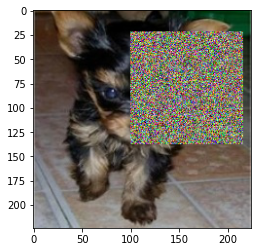

In [63]:
plt.imshow(to_img(noised[6]))

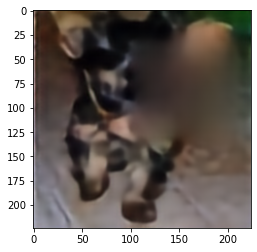

In [64]:
# noise = torch.randn_like(X[0])
with torch.no_grad():
    dens = forward_cut(noised, model, -2)
    dens = generator(dens)
    plt.imshow(to_img(dens[6]))

In [29]:
epochs = 50

In [75]:
opt.param_groups[0]['lr']

0.0005451634383685182

In [79]:
for epoch in trange(epochs):
#     opt.param_groups[0]['lr'] *= 0.97
    for X in pretrain_loader:
        opt.zero_grad()
        
        noised = X.clone()
        for i in range(len(X)):
            sq_sz = torch.randint(low=56, high=168, size=(1,))[0]
            sx = torch.randint(low=0, high=224-sq_sz, size=(1,))[0]
            ex = sx + sq_sz
            sy = torch.randint(low=0, high=224-sq_sz, size=(1,))[0]
            ey = sy + sq_sz
            noised[i,:,sx:ex,sy:ey] = torch.randn_like(noised[i,:,sx:ex,sy:ey])
        X = X.to(device)
        noised = noised.to(device)
        
        hid = forward_cut(noised, model, -2)
        pred = generator(hid)
        
        loss = F.mse_loss(pred, X)
        
        loss.backward()
        opt.step()
        
        wandb.log({'loss':loss.item()})
    wandb.log({'lr':opt.param_groups[0]['lr']})

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [80]:
torch.save(model, 'inpaint-pretrain2.tm')

In [70]:
model = torch.load('inpaint-pretrain.tm')

In [81]:
#model.to(device)

final_opt = optim.Adam(model.parameters(), lr=5e-3)

In [82]:
hist = []
for epoch in trange(25):
    final_opt.param_groups[0]['lr'] *= 0.96
    for X, y in train_loader:
        final_opt.zero_grad()
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        
        loss = F.cross_entropy(pred, y)
        
        loss.backward()
        final_opt.step()
        hist.append(loss.item())
        
#         wandb.log({'final loss':loss.item()})
#     wandb.log({'final lr':final_opt.param_groups[0]['lr']})

  0%|          | 0/25 [00:00<?, ?it/s]

In [83]:
model = model.train(False)

In [84]:
infer_path, _, infer_files = next(os.walk('./data/test/'))

ans = []
classes_stat = []
for file in infer_files:
    filename = infer_path+'/'+file
    img = torch.tensor(plt.imread(filename), dtype=torch.float32)
    img = img.transpose_(0,2).unsqueeze(0)

    img = normalization(img)
    with torch.no_grad():
        class_idx = model(img.to(device)).argmax()
    classes_stat.append(class_idx.item())
    ans.append((file, labdat.classes[class_idx.item()]))

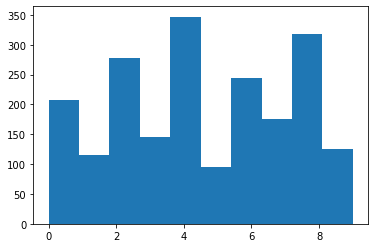

In [85]:
plt.hist(classes_stat, bins=10);

In [86]:
with open('./result_inpaint-pretrain0.csv', 'w') as f:
    print('id,class', file=f)
    for file, classn in ans:
        print(f'{file},{classn}', file=f)

In [ ]:
labdat.classes